<a href="https://colab.research.google.com/github/AvinashBisram/LLMResearch/blob/main/LayoutParserDemonstration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Layout Parser Demonstration
=======================

By: Avinash Bisram  
Guided by: Professor Giancarlo Crocetti (St. John's University)  
Last Updated: May 2023

**Description:** The purpose of this notebook is to explore the capabilities of [LayoutParser](https://layout-parser.github.io/) and it's capability of identifying the structure of a PDF. A pre-trained model is used to categorize various structure elements before novel code is used to populate the text, id, parent, and next attributes for each identified block.

**Notebook Organization**:  
1. How to convert a PDF to JPG
2. Generating a Layout object
3. Filtering layout confidence scores
4. Populating Layout attributes  
  * Text  
  * ID, Parent, and Next
5. Final Layout
6. Next Steps

**Note:** This notebook is intended to be executed in Google Colab. If run in Jupyter Notebooks, some features may be incompatible such as the file import and Detectron package.

In [ ]:
# Installing necessary libraries

# Note: It may be necessary to restart the runtime after executing this cell the first time (refer to console output)

!sudo apt install tesseract-ocr

!pip install pdf2jpg
!pip install layoutparser
!pip install layoutparser[OCR]
!pip install opencv-contrib-python
!pip install 'git+https://github.com/facebookresearch/detectron2.git@v0.4#egg=detectron2'
!pip install Pillow
!pip install pytesseract

In [2]:
# Importing necessary packages

from pdf2jpg import pdf2jpg
import cv2
from google.colab.patches import cv2_imshow
import pandas as pd
try:
    from PIL import Image
except ImportError:
    import Image
import layoutparser as lp
import pytesseract
import matplotlib.pyplot as plt
from IPython.display import clear_output

# Step 1: Convert desired PDF to JPG

The first step to using LayoutParser to detect the layout is to convert the desired PDF to a LayoutParser-compatible file type.

As seen in the LayoutParser documentation [here](https://layout-parser.readthedocs.io/en/latest/api_doc/models.html#layoutparser.models.Detectron2LayoutModel.detect), the object passed into the method must be a numpy.ndarray or a PIL.image.  

While PDFs cannot be convert into PIL.images, JPEGs can, so we must convert our desired PDF to JPG using the **pdf2jpg** Python library.

In [3]:
# Import the desired PDF from computer storage to google colab

# The PDF used in this notebook can be accessed and downloaded from here: https://pubmed.ncbi.nlm.nih.gov/36334240/ 

from google.colab import files
files.upload()
clear_output()

In [4]:
# Convert to PDF to JPEGs of each page

# After executing this cell, the JPEGS will be found in folder '/content/Influence_of_Resistance_Training_Proximity_to_Failure_on_Skeletal_Muscle_Hypertrophy.pdf_dir'

inputpath = r"Influence_of_Resistance_Training_Proximity_to_Failure_on_Skeletal_Muscle_Hypertrophy.pdf"
outputpath = r""
result = pdf2jpg.convert_pdf2jpg(inputpath,outputpath, pages="ALL")
#result

# Step 2: Using LayoutParser to detect the structure of an Image

The next step after converting the desired PDF to JPGs, is to choose a model to detect the layout. LayoutParser provides a few [pre-trained models](https://layout-parser.readthedocs.io/en/latest/notes/modelzoo.html) in the ModelZoo that can be used before attempting to train your own.  

Each model was trained on different image types and identify different structural components of documents so it is important to use the model that was trained on documents most similar to our desired PDF structure.

The document being used in this notebook is from PubMed and shares the structure of documents used to train the PubLayNet family of models in the LayoutParser ModelZoo. Furthermore, the model detects the blocks that we are trying to identify such as Text, Title, List, Tables, and Figures.

In [5]:
# Initializing the model we will be using (PubLayNet)

# You can explore the pre-trained models provided by LayoutParser and the objects each detects here: https://layout-parser.readthedocs.io/en/latest/notes/modelzoo.html

PLNmaskXmodel = lp.models.Detectron2LayoutModel(
            config_path ='lp://PubLayNet/mask_rcnn_X_101_32x8d_FPN_3x/config', # In model catalog
            label_map   ={0: "Text", 1: "Title", 2: "List", 3:"Table", 4:"Figure"}, # In model`label_map`
        )

config.yaml?dl=1: 8.19kB [00:01, 4.34kB/s]
model_final.pth?dl=1: 856MB [00:09, 87.0MB/s]                          


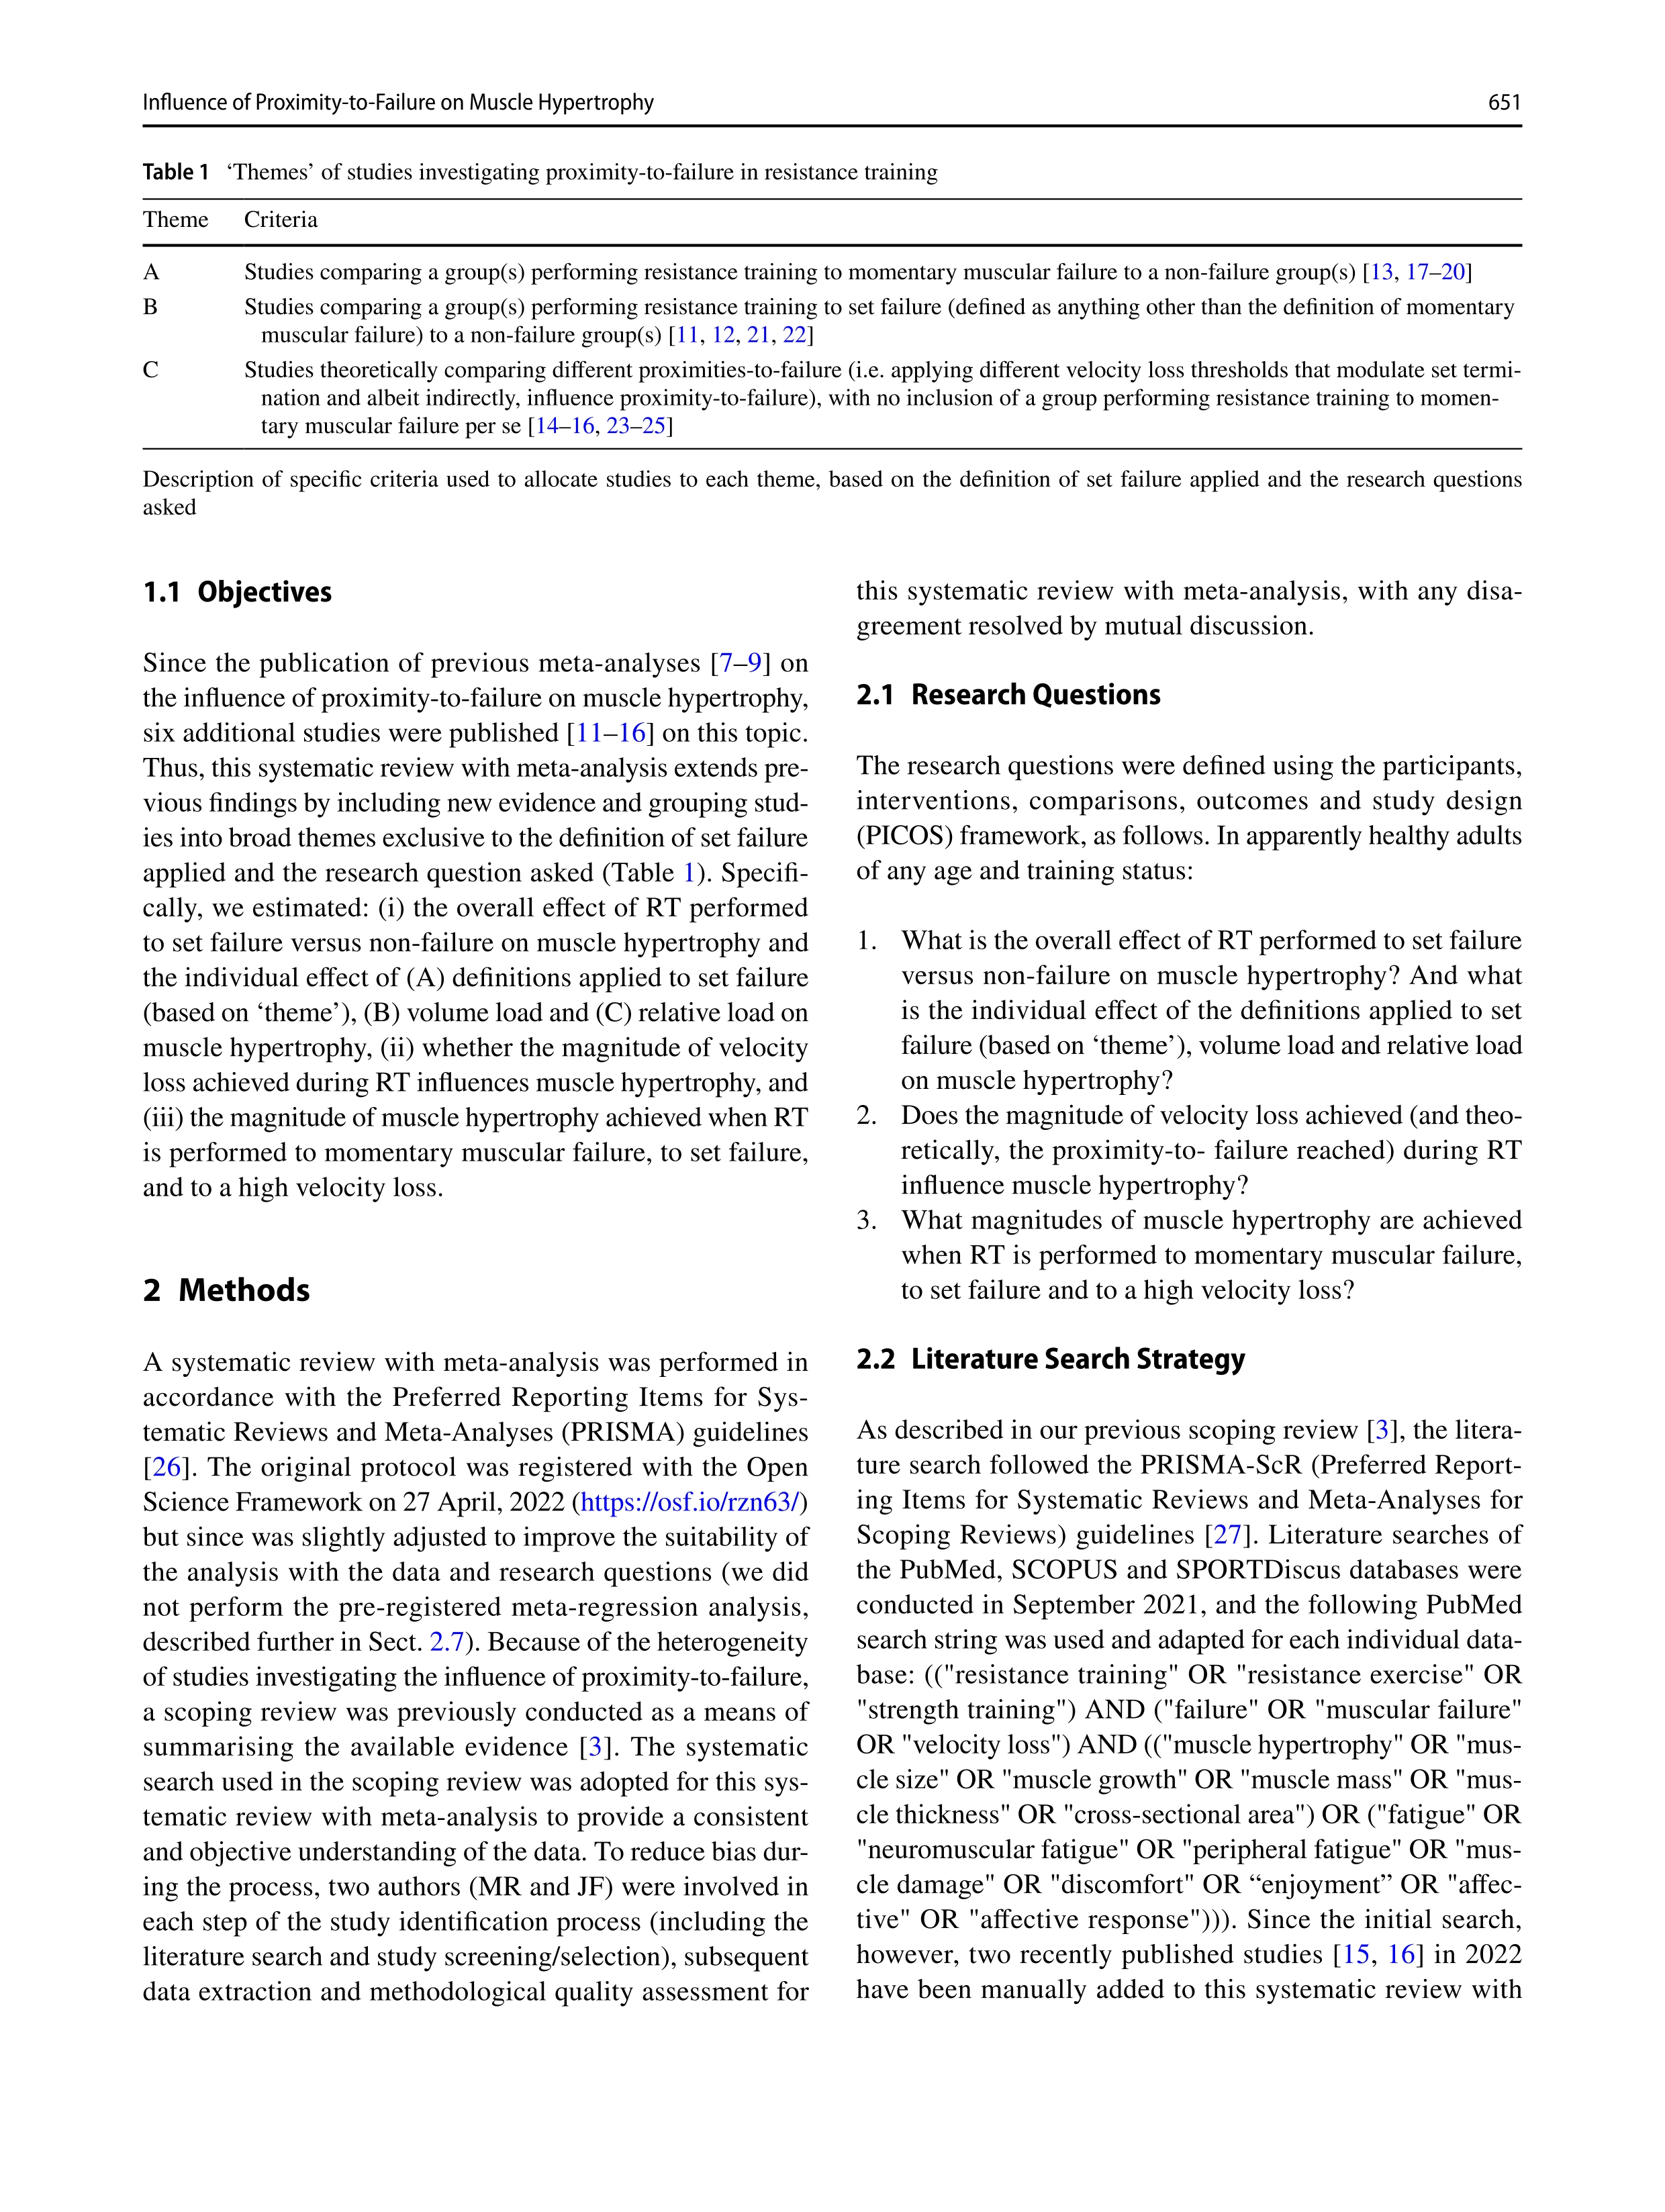

In [6]:
# Next, we need to load the jpg of one page as a PIL.image object

# Convert JPG to PIL.Image
image = cv2.imread('/content/Influence_of_Resistance_Training_Proximity_to_Failure_on_Skeletal_Muscle_Hypertrophy.pdf_dir/2_Influence_of_Resistance_Training_Proximity_to_Failure_on_Skeletal_Muscle_Hypertrophy.pdf.jpg')

# Display the image
cv2_imshow(image)

In [7]:
# Lastly we need to use the PubLayNet model to detect the layout of the page

rawLayout = PLNmaskXmodel.detect(image)

/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [8]:
# To view the structure of the rawLayout object, uncomment and execute this cell

#rawLayout

# Step 3: Confidence Filtering

After producing the raw layout object, we need to filter the layout blocks with confidence scores above a certain threshold. As we can see below, the Layout without filtering produces many overlapping blocks that contain redundant information or are incorrectly identified by the model. After filtering for blocks with scores above 0.8 (chosen after trial and error for this specific image) the structure only contains non-overlapping blocks that we desire.

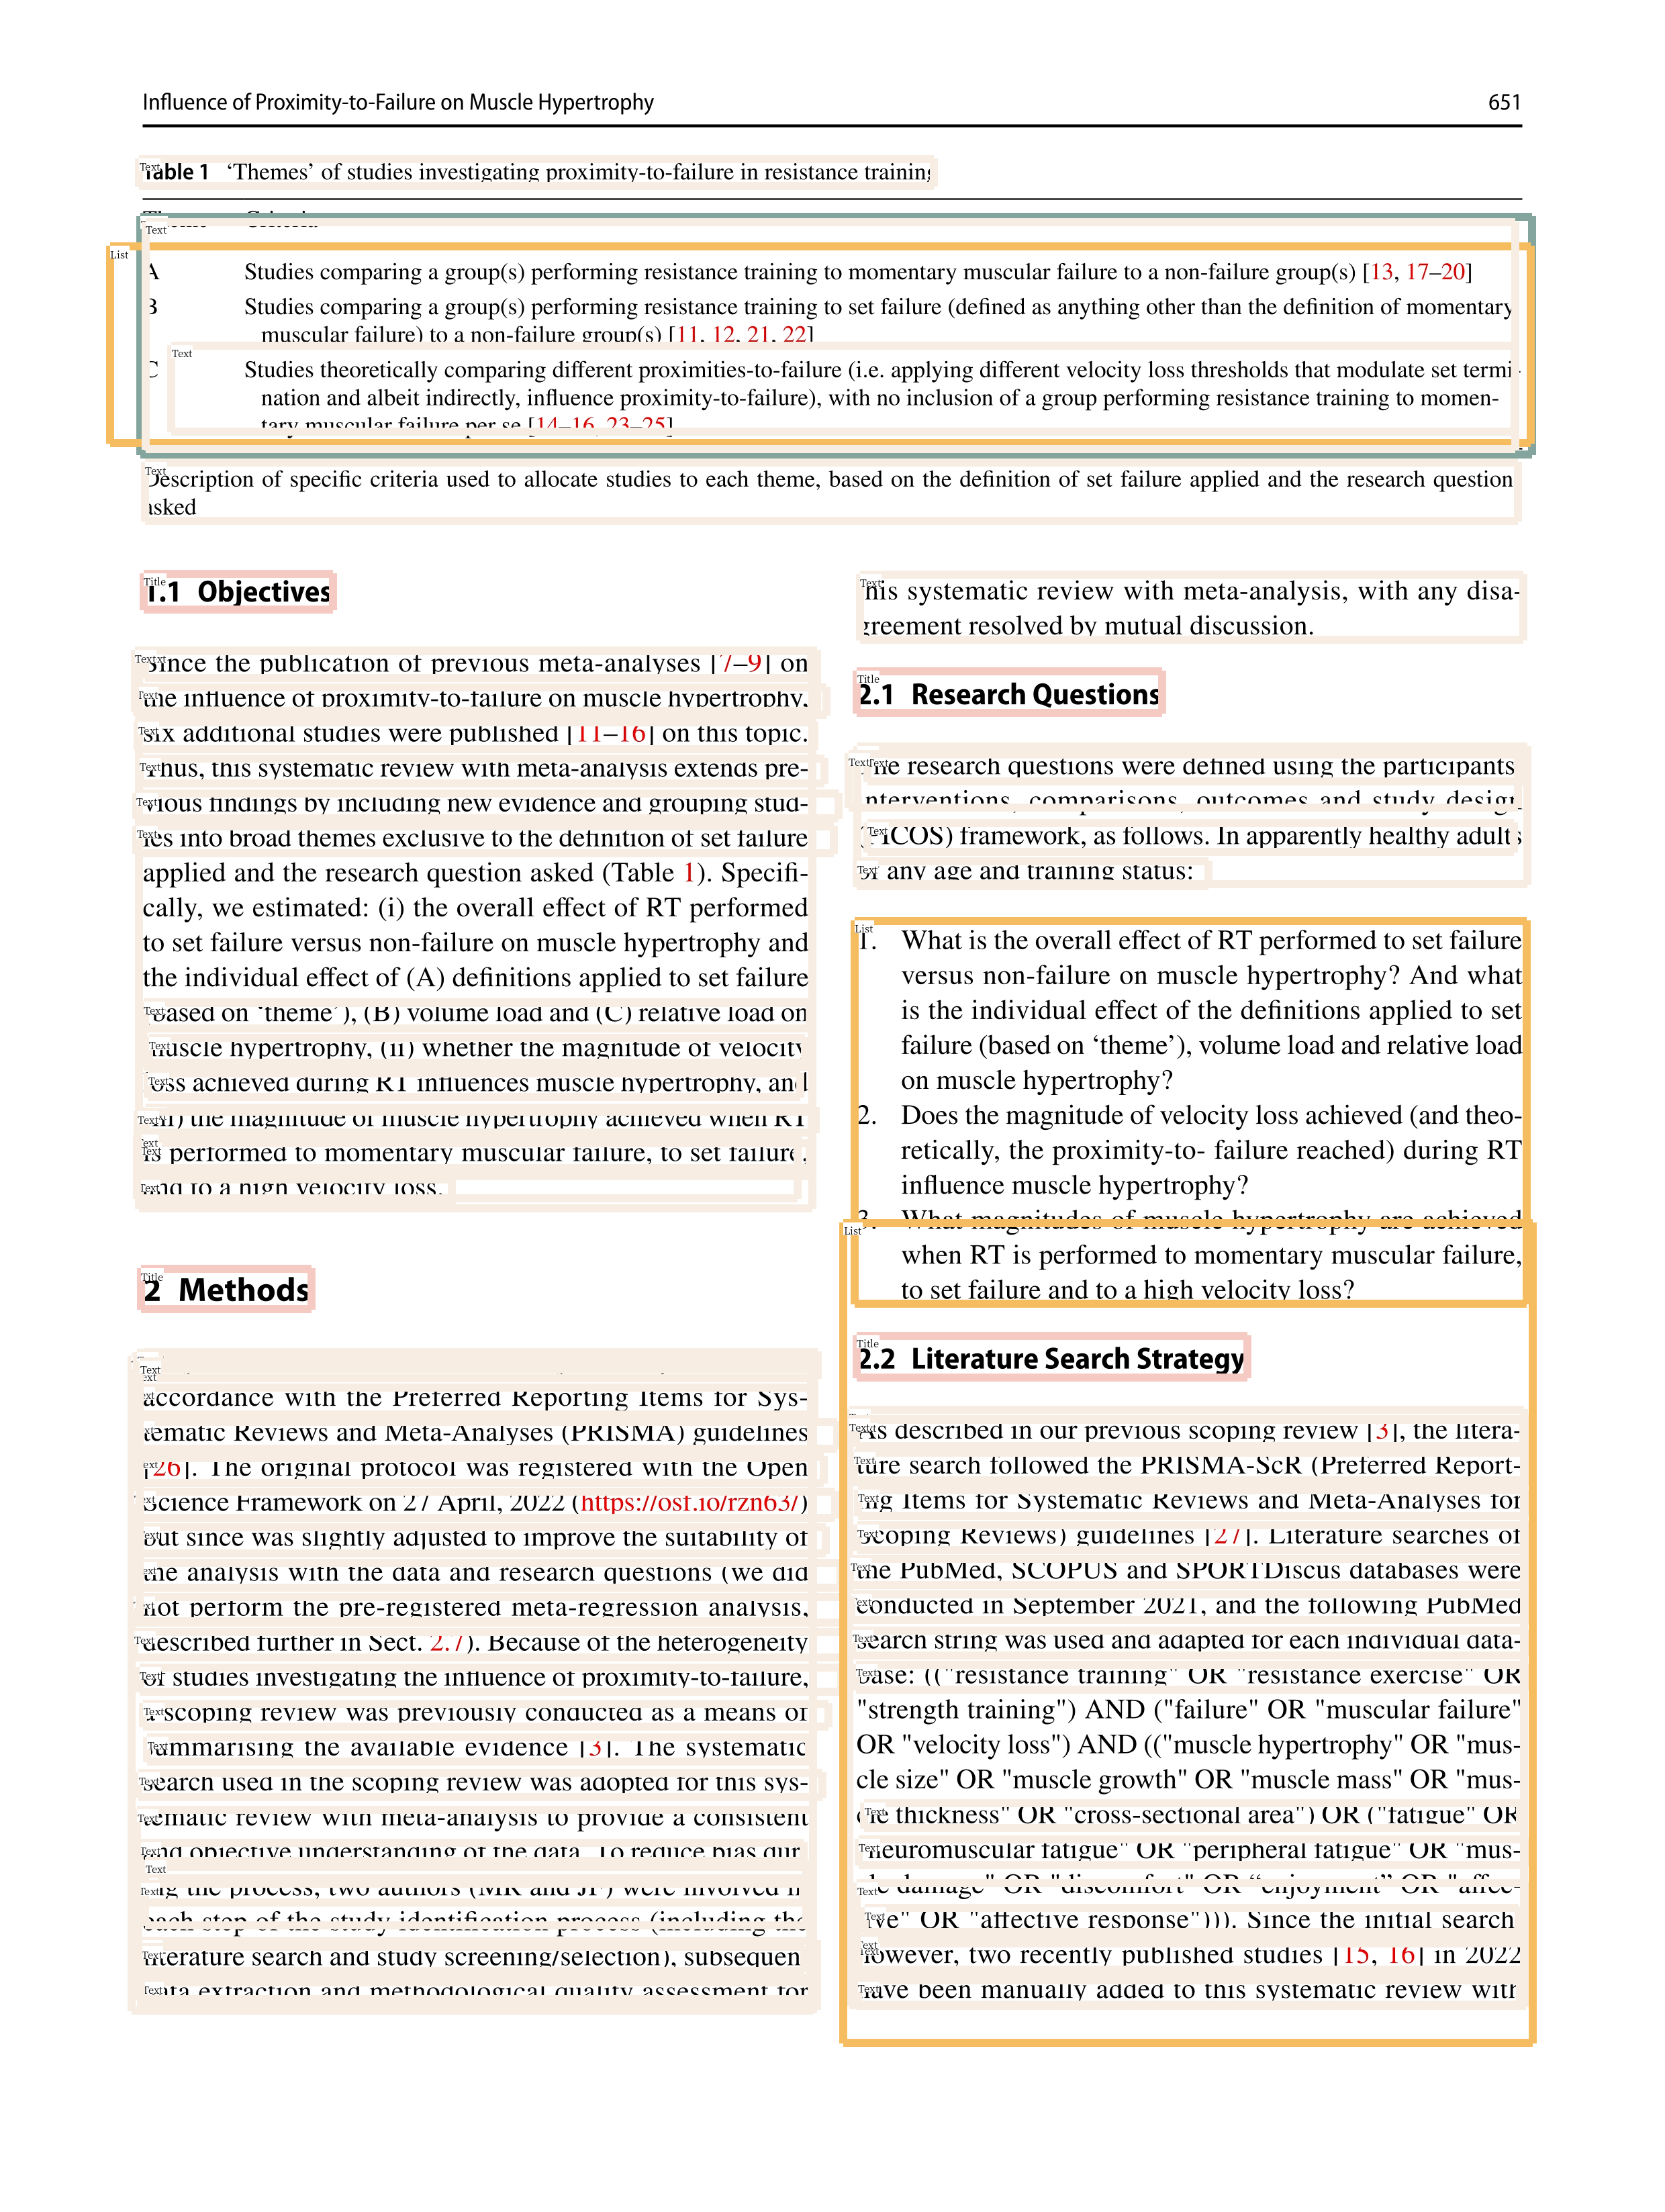

In [9]:
# Visualizing the rawLayout detected by the model

lp.visualization.draw_box(image,rawLayout,show_element_type=True)

# As we can see below, there are many overlapping blocks (especially with textboxes identifying individual lines rather than the overall paragraph structure).

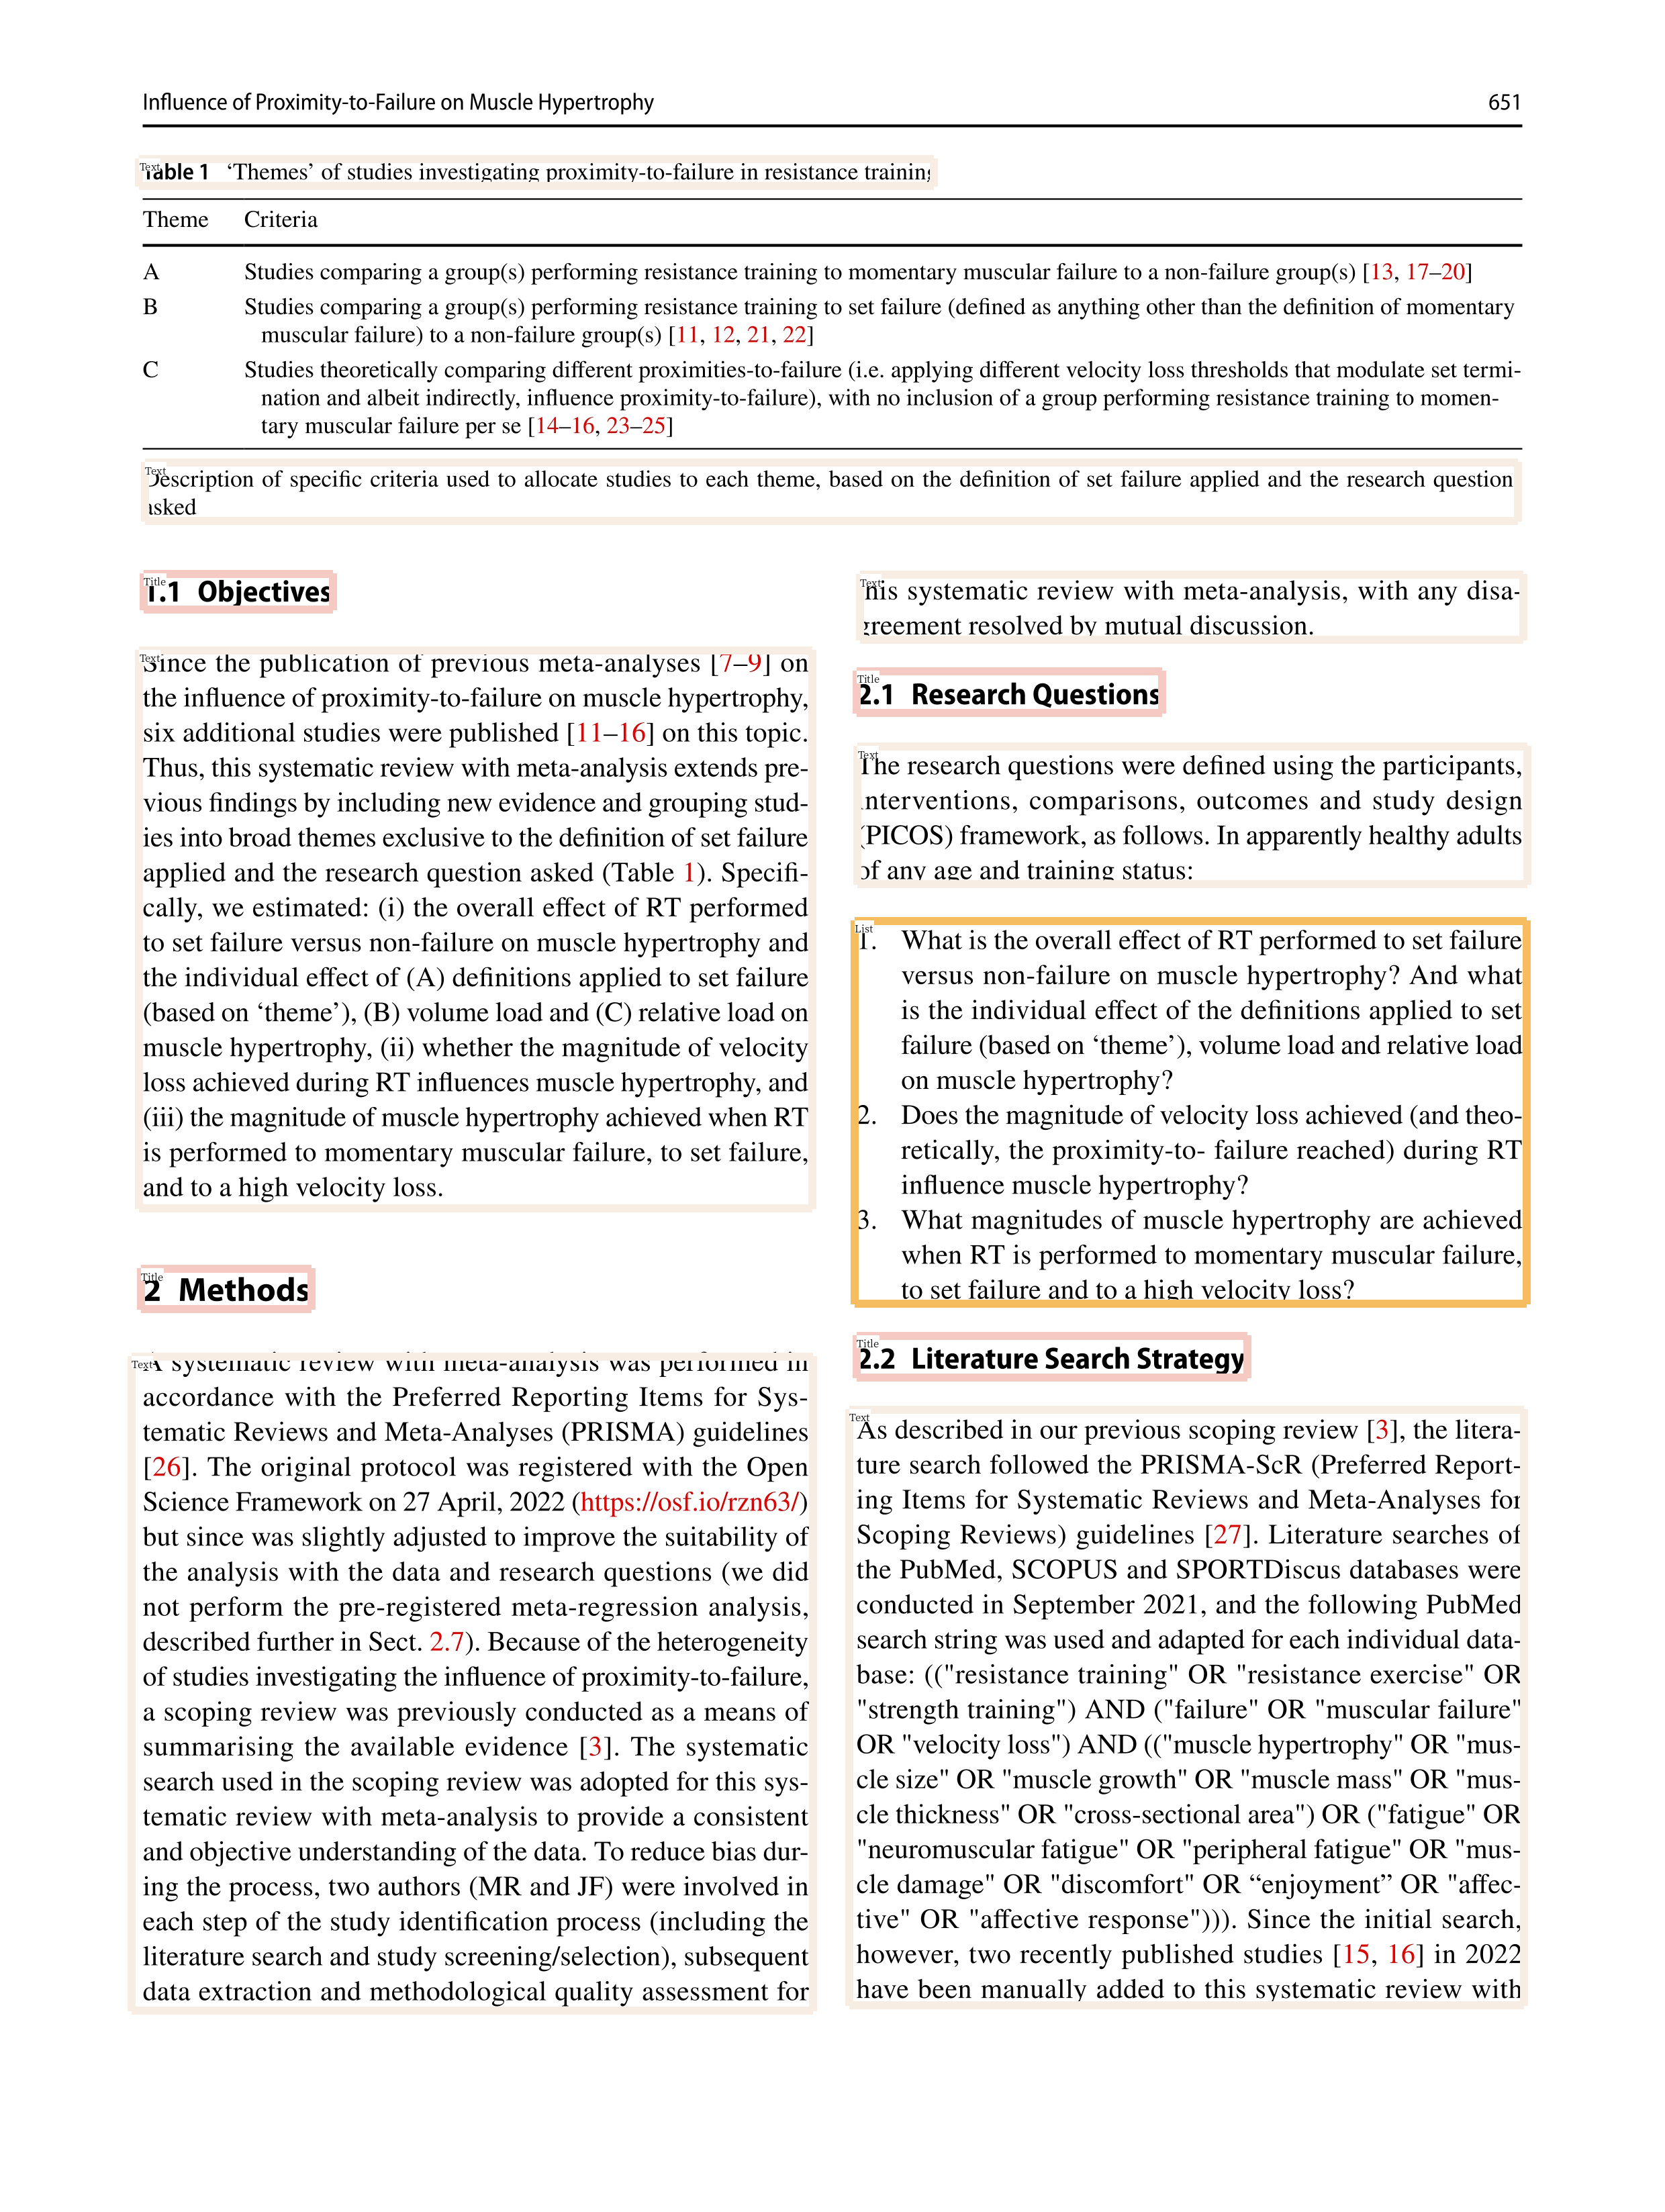

In [10]:
# Filtering the layout for blocks with scores above 0.8

filteredLayout = lp.Layout([block for block in rawLayout if block.score>0.8])
lp.visualization.draw_box(image,filteredLayout,show_element_type=True)

In [11]:
# Lastly, we can look at the attributes of the newly filtered layout

filteredLayout._blocks

# Notice the coordinates of each block as well as the type (Title, Text, List, etc.) but text, id, parent, and next are None.
# We would like to populate these attributes to contain the text of each block as well as their relationships (relating each block to their respective section title or parent).

[TextBlock(block=Rectangle(x_1=1276.767333984375, y_1=999.4418334960938, x_2=1730.1151123046875, y_2=1062.192138671875), text=None, id=None, type=Title, parent=None, next=None, score=0.9964054822921753),
 TextBlock(block=Rectangle(x_1=210.12425231933594, y_1=1889.978759765625, x_2=463.62188720703125, y_2=1950.4774169921875), text=None, id=None, type=Title, parent=None, next=None, score=0.9962389469146729),
 TextBlock(block=Rectangle(x_1=1273.3641357421875, y_1=1371.017333984375, x_2=2273.6806640625, y_2=1942.9447021484375), text=None, id=None, type=List, parent=None, next=None, score=0.9952114224433899),
 TextBlock(block=Rectangle(x_1=214.14373779296875, y_1=854.033935546875, x_2=495.8356628417969, y_2=908.8880004882812), text=None, id=None, type=Title, parent=None, next=None, score=0.9951741099357605),
 TextBlock(block=Rectangle(x_1=1276.1778564453125, y_1=1989.5023193359375, x_2=1857.0096435546875, y_2=2052.3291015625), text=None, id=None, type=Title, parent=None, next=None, score=0.

It is important to note that the filteredLayout is created using list comprehension of the blocks in the rawLayout. Due to this, the layout blocks are referenced not copied, and once we populate the missing attributes in the next step, we will see the changes in the respective rawLayout elements as well. In other words, filteredLayout is not a "deep copy" of the desired rawLayout blocks.

# Step 4: Populating Missing Layout Attributes

As seen above, the coordinates of each layout block is detected by the model but text, id, parent, and next attributes are not. 

We had originally assumed that the LayoutParser model detection would automatically populate these attributes but as seen above, that was not true. Therefore, we need to create our own code to gather information about the different blocks and populate them ourselves.

The following code will populate each one of these attributes for the filtered blocks.

## 4a. Populate Text Attribute

In [12]:
'''
Description: Populates the text attribute of blocks in a provided Layout object IN PLACE
'''

def populateText(layout):
    
    # Identifying the blocks with types Text and Title (these are the only blocks we want to populate text in)
    textAndTitleBlocks = lp.Layout([block for block in layout._blocks if (block.type=='Text' or block.type=='Title')])

    # For each Text or Title block...
    for block in textAndTitleBlocks:
      # Temporariy store an image of each block
      segment_image = (block.pad(left=5, right=5, top=5, bottom=5).crop_image(image))
      # Use pytesseract to identify the text contained in each image
      extractedInformation = pytesseract.image_to_string(segment_image)
      # Removing string literals from the extracted text
      if type(extractedInformation)==str:
        extractedInformation = extractedInformation.replace('-\n','')
        extractedInformation = extractedInformation.replace('\n',' ')
        if extractedInformation[-2:]==' \x0c':
          extractedInformation = extractedInformation[:-2]        
      # Set the text attribute of each respective block to their text
      block.set(text=extractedInformation, inplace=True)

In [13]:
# Call our text population method on the filteredLayout

populateText(filteredLayout)

In [14]:
# Display the text attributes of blocks in filteredLayout

filteredLayout.get_info('text')

['2.1 Research Questions',
 '2 Methods',
 None,
 '1.1 Objectives',
 '2.2 Literature Search Strategy',
 'Table 1 ‘Themes’ of studies investigating proximity-to-failure in resistance training',
 'this systematic review with meta-analysis, with any disagreement resolved by mutual discussion.',
 'Since the publication of previous meta-analyses [7—9] on the influence of proximity-to-failure on muscle hypertrophy, six additional studies were published [11-16] on this topic. Thus, this systematic review with meta-analysis extends previous findings by including new evidence and grouping studies into broad themes exclusive to the definition of set failure applied and the research question asked (Table 1). Specifically, we estimated: (i) the overall effect of RT performed to set failure versus non-failure on muscle hypertrophy and the individual effect of (A) definitions applied to set failure (based on ‘theme’), (B) volume load and (C) relative load on muscle hypertrophy, (ii) whether the magni

## 4b. Populate ID, Parent, and Next Attributes

Lastly, we need to assign the id, parent, and next attributes of filtered blocks.

This process is specific to a 2-column document structure. We first identify the left and right blocks and combine them into one list to contain the logical text sequence of the document. 

Once this combined list is produced, the ID attributes are assigned to elements incrementally.

Next, we want each Title block to be referenced as the 'parent' of each subsequent non-Title block.

Finally, we assign the 'next' attribute of each block to be the subsequent block when sorted by y_1 coordinates (the top left coordinate of each block). This is because after combining the list of left and right block elements, the logical structure of blocks are vertical (blocks of text are read from the top to the bottom of each column).

In [15]:
'''
Description: Populates the text attribute of blocks in a provided Layout object IN PLACE
'''

# The original image used to detect the layout must be provided to identify the coordinate cutoff of left and right columns
def populateIdParentAndNext(layout, image):
    # Currently the Layout is sorted by the 'score' attribute so we need to rearrange them into left and right blocks
    
    # Separate the layout into left and right blocks
    column_cutoff = image.shape[1] / 2
    left_blocks = [block for block in layout._blocks if block.block.x_1 < column_cutoff]
    right_blocks = [block for block in layout._blocks if block.block.x_1 >= column_cutoff]

    # Helper function to retrieve y_1 of Layout Block
    def gety1(block):
      return block.block.y_1
    
    # Sort the left blocks by y_1
    left_blocks.sort(key=gety1)

    # Sort the right blocks by y_1
    right_blocks.sort(key=gety1)

    # Append the two lists (creating a logical structure of left column top-to-bottom + right column top-to-bottom blocks)
    left_blocks.extend(right_blocks)

    currentTitleID = -1
    for i,block in enumerate(left_blocks):
    # ID ATTRIBUTE POPULATION    
        block.set(id=i, inplace=True)

    # PARENT ATTRIBUTE POPULATION
        # Assumption: Title blocks CANNOT have parents (we will need to improve on this to extend to title-subtitle relationships)
        if (block.type=='Title'): # Whenever a Title block is identified, save it as the currentTitle block
            currentTitleID = block.id
        
        else: # When a non-Title block is identified, assign it's parent to be the currentTitle
            block.set(parent=currentTitleID, inplace=True)

    # NEXT ATTRIBUTE POPULATION
        if i==len(left_blocks)-1:
            break
        # Set the next attribute of each block to be the ID of the subsequent block (if possible)
        block.set(next=i+1, inplace=True)

In [16]:
# Call our ID, Parent, and Next attribute population method to the filteredLayout

populateIdParentAndNext(filteredLayout, image)

In [17]:
# Inspecting the IDs of the filtered blocks

filteredLayout.get_info('id')

[7, 4, 9, 2, 10, 0, 6, 3, 11, 5, 1, 8]

In [18]:
# Inspecting the Parents of filtered blocks

filteredLayout.get_info('parent')

# None indicates a Title block
# -1 indicates the block appears before the first Title block

[None, None, 7, None, None, -1, 4, 2, 10, 4, -1, 7]

In [19]:
# Inspecting the Next attributes of filtered blocks

filteredLayout.get_info('next')

[8, 5, 10, 3, 11, 1, 7, 4, None, 6, 2, 9]

In [20]:
# List Comprehension for checking parent attributes

# Verify the blocks where parent == -1 (Should be the two elements before the first title)
[block for block in filteredLayout if block.parent==-1]

# Verify the blocks where parent == None (Should only be the Title blocks)
#[block for block in filteredLayout if block.parent==None]

# Use the following line to verify each block where parent == a positive integer (see valid parent integers two cells above this)
# Use the cell below to verify the text of each parent block and confirm the correct relationship
[block for block in filteredLayout if block.parent==4]

[TextBlock(block=Rectangle(x_1=1281.3648681640625, y_1=855.6300659179688, x_2=2268.964111328125, y_2=953.7931518554688), text=this systematic review with meta-analysis, with any disagreement resolved by mutual discussion., id=6, type=Text, parent=4, next=7, score=0.9872375726699829),
 TextBlock(block=Rectangle(x_1=196.2528076171875, y_1=2020.166748046875, x_2=1210.762451171875, y_2=2995.814208984375), text=A systematic review with meta-analysis was periormed 1n accordance with the Preferred Reporting Items for Systematic Reviews and Meta-Analyses (PRISMA) guidelines [26]. The original protocol was registered with the Open Science Framework on 27 April, 2022 (https://osf.io/rzn63/) but since was slightly adjusted to improve the suitability of the analysis with the data and research questions (we did not perform the pre-registered meta-regression analysis, described further in Sect. 2.7). Because of the heterogeneity of studies investigating the influence of proximity-to-failure, a scopi

In [21]:
# Find the block with specified ID (used to verify text of parents with positive integer values)

[block for block in filteredLayout if block.id==4]

[TextBlock(block=Rectangle(x_1=210.12425231933594, y_1=1889.978759765625, x_2=463.62188720703125, y_2=1950.4774169921875), text=2 Methods, id=4, type=Title, parent=None, next=5, score=0.9962389469146729)]

# Final Layout

In this notebook we demonstrated...
1. How to convert a desired PDF to a folder of JPGs (one per page)
2. Use a pre-trained LayoutParser model to detect the layout of a page
3. Refine the produced layout by filtering above a desired confidence score threshold
4. Use pytesseract and user-defined functions to populate the missing attributes of Layout Blocks (text, id, parent, and next).

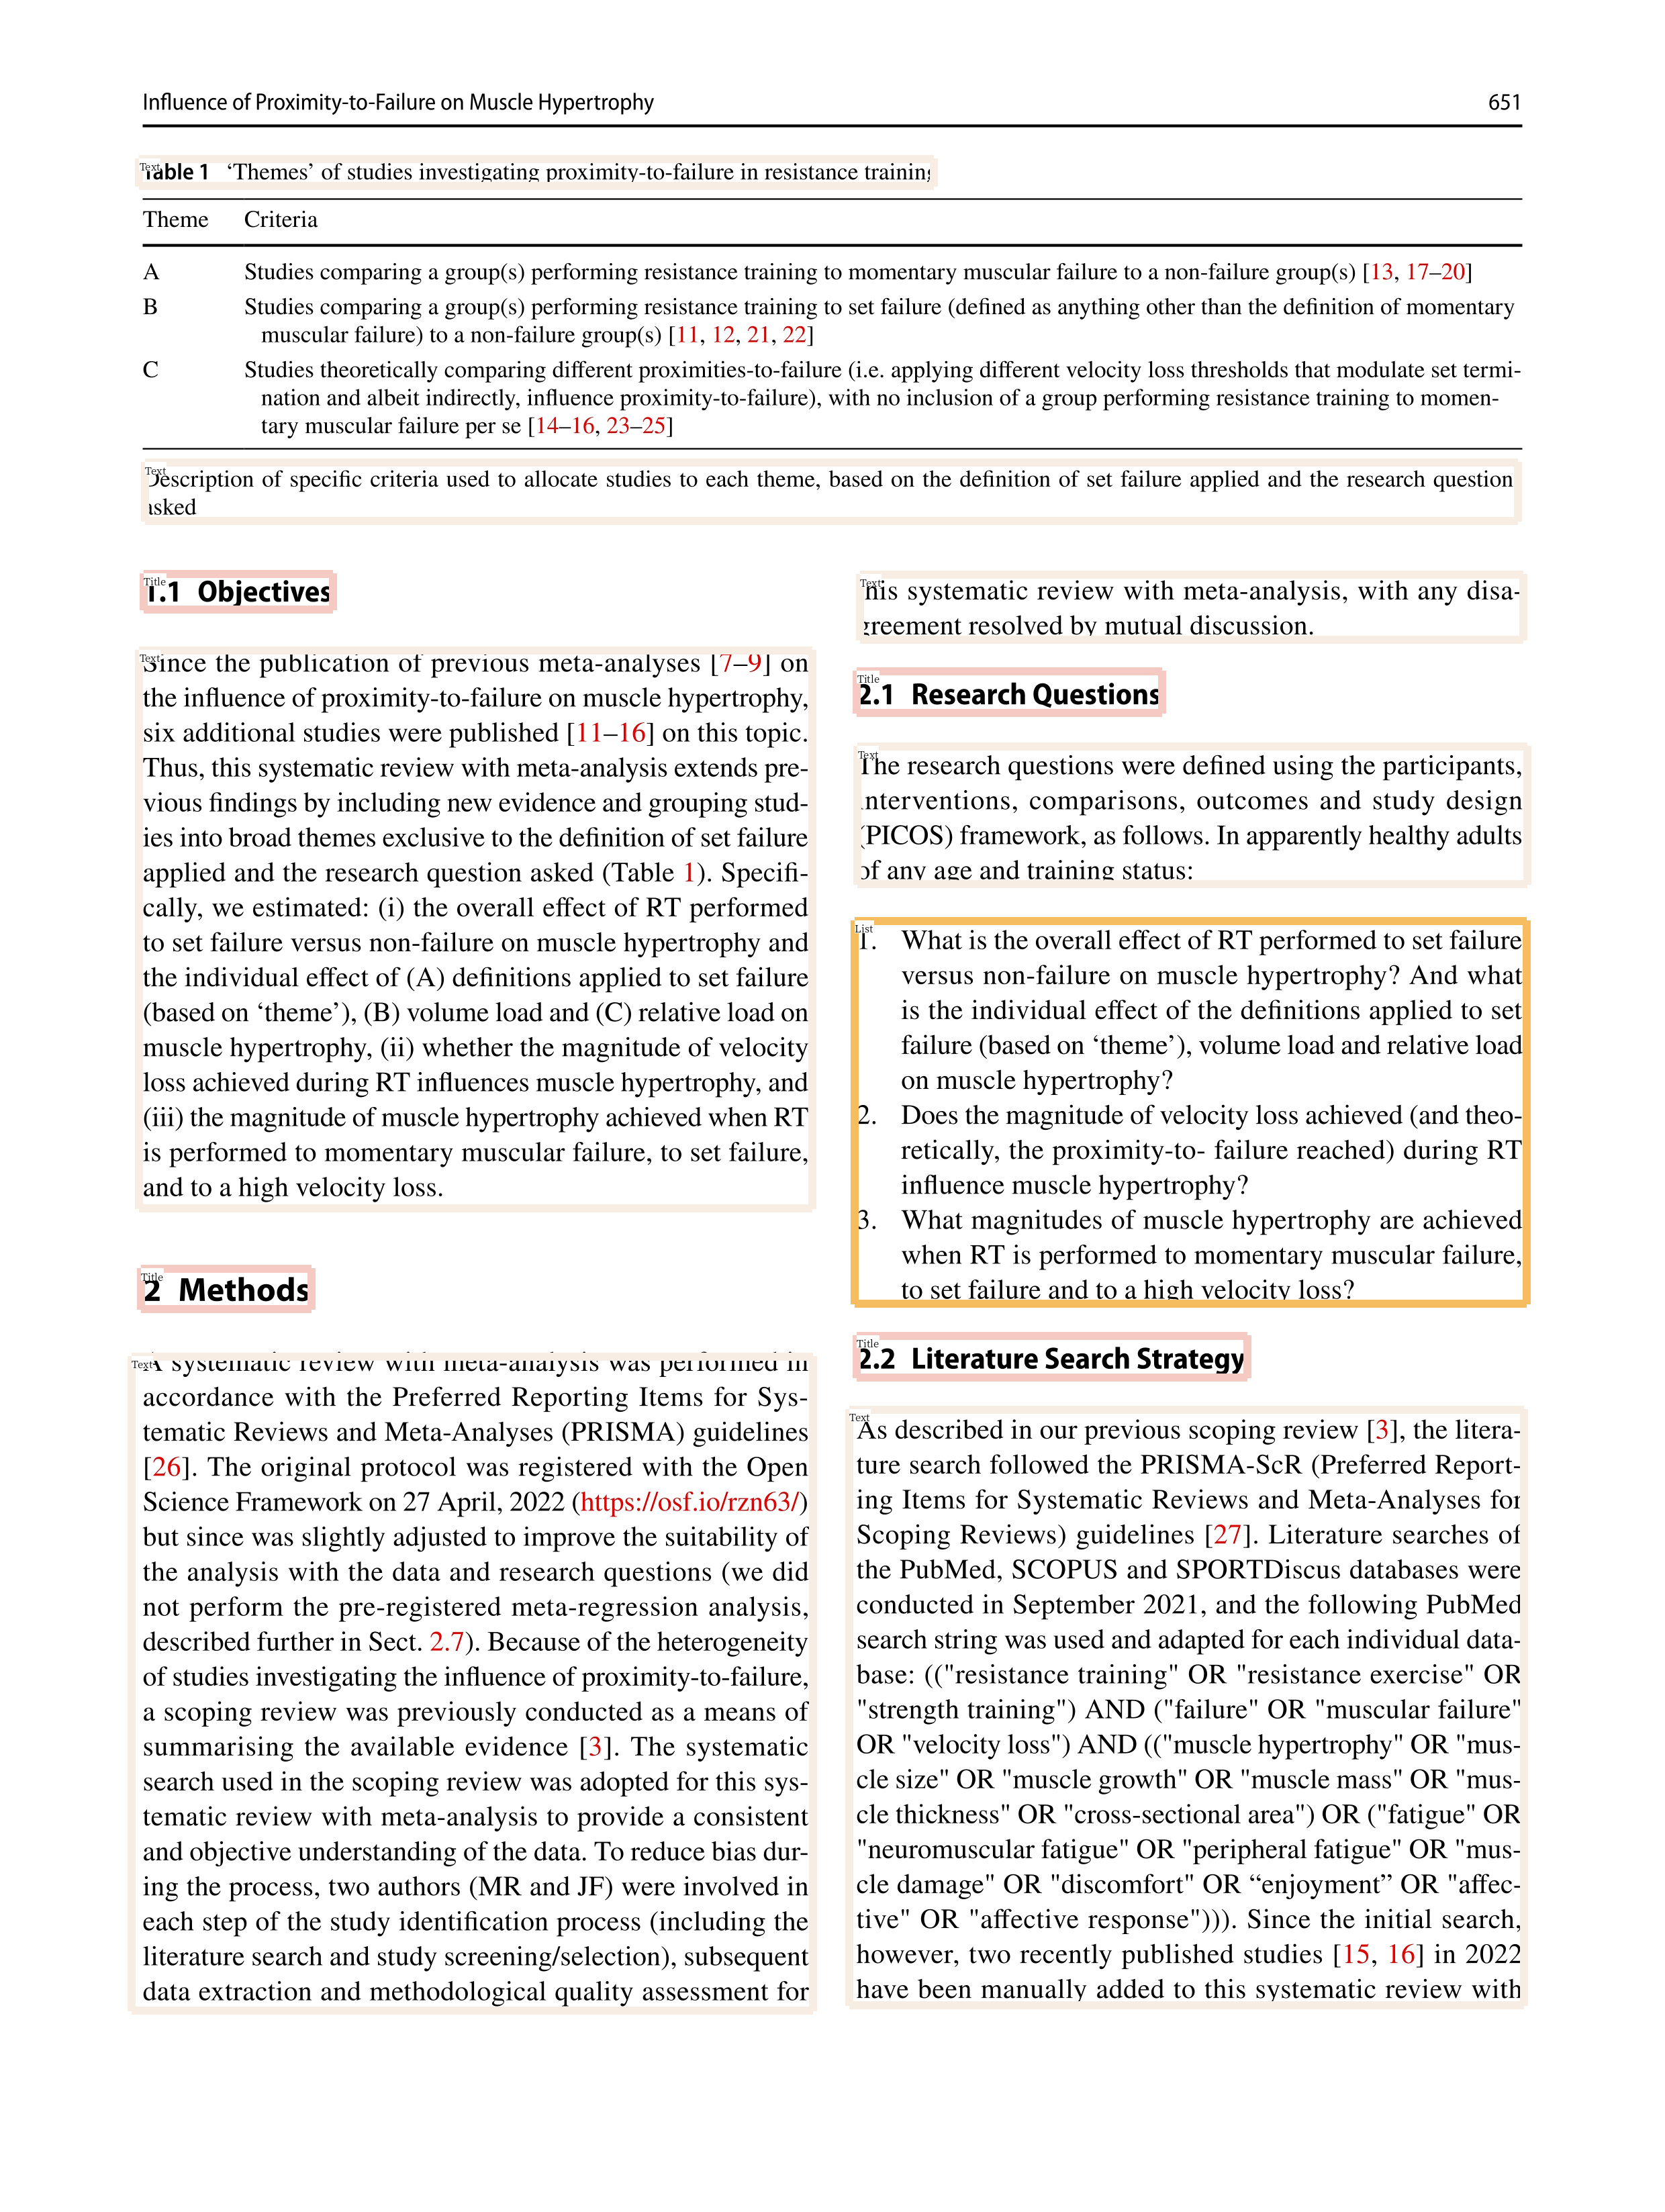

In [22]:
# Visualizing the final filtered layout

lp.visualization.draw_box(image,filteredLayout,show_element_type=True)

In [23]:
# Inspecting the layout AFTER attribute population

filteredLayout._blocks

[TextBlock(block=Rectangle(x_1=1276.767333984375, y_1=999.4418334960938, x_2=1730.1151123046875, y_2=1062.192138671875), text=2.1 Research Questions, id=7, type=Title, parent=None, next=8, score=0.9964054822921753),
 TextBlock(block=Rectangle(x_1=210.12425231933594, y_1=1889.978759765625, x_2=463.62188720703125, y_2=1950.4774169921875), text=2 Methods, id=4, type=Title, parent=None, next=5, score=0.9962389469146729),
 TextBlock(block=Rectangle(x_1=1273.3641357421875, y_1=1371.017333984375, x_2=2273.6806640625, y_2=1942.9447021484375), text=None, id=9, type=List, parent=7, next=10, score=0.9952114224433899),
 TextBlock(block=Rectangle(x_1=214.14373779296875, y_1=854.033935546875, x_2=495.8356628417969, y_2=908.8880004882812), text=1.1 Objectives, id=2, type=Title, parent=None, next=3, score=0.9951741099357605),
 TextBlock(block=Rectangle(x_1=1276.1778564453125, y_1=1989.5023193359375, x_2=1857.0096435546875, y_2=2052.3291015625), text=2.2 Literature Search Strategy, id=10, type=Title, p

In [24]:
# As was said before, since filteredLayout is not a "deep copy" of the original rawLayout created during layout detection, inspecting rawLayout will also contain our filteredLayout blocks

#rawLayout._blocks

# Next Steps

This notebook shows that is possible to use LayoutParser to identify the structure of a PDF and populate missing attributes to store the texts and create relationships between the Titles and content of different sections, as well as the logical organization of identified blocks using coordinates.

Next Steps include:
1. Identifying the relationship between different titles (document titles, section titles, subtitles, etc.)
2. Maintaining the relationships of blocks across multiple pages of the same PDF.
3. Applying the findings of this notebook to documents of different structures (Prescribing Information documents, varying column numbers, etc.)
4. Training novel models to more accurately identify the structure of varying document types.